In [71]:
import pandas as pd 
import numpy as np 


hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)
# print(hf_series)
data = hf_series
annualization_factor= 12

etfs = pd.read_excel("./../data/multi_asset_etf_data.xlsx", sheet_name="excess returns")
data = etfs 
data = data.set_index('Date')


## Portfolio

In [72]:
import numpy as np 

def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])

def gmv_weights(returns):
    ones = np.ones(returns.columns.shape)
    cov = returns.cov()* annualization_factor
    cov_inv = np.linalg.inv(cov)
    scaling = 1/(np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_weights_df = pd.DataFrame(gmv_tot, index=returns.columns, columns=['GMV Weights'])
    return gmv_weights_df

def risk_parity_weights(returns): 
    asset_var = returns.var().to_dict() 
    asset_inv_variance_dict = {asset: 1 / variance for asset, variance in asset_var.items()}
    rp_weights_df = pd.DataFrame.from_dict(asset_inv_variance_dict, orient='index', columns=['RP Weights'])
    return rp_weights_df

def calc_mv_portfolio(mean_rets, cov_matrix, target=None):
    w_tan = tangency_weights(mean_rets)

    if target is None:
        return w_tan

    w_gmv = gmv_weights(mean_rets)
    delta = (target - mean_rets @ w_gmv) / (mean_rets @ w_tan - mean_rets @ w_gmv)
    return delta * w_tan + (1 - delta) * w_gmv

def mv_portfolio_excess_returns(target_ret, ex_ret):
    
    mu_tilde = ex_ret.copy().mean()
    Sigma_adj = ex_ret.copy().cov()
    Sigma_inv = np.linalg.inv(Sigma_adj)
    N = Sigma_adj.shape[0]
    delta_tilde = ((np.ones(N) @ Sigma_inv @ mu_tilde)/(mu_tilde @ Sigma_inv @ mu_tilde)) * target_ret
    tan_wts = tangency_weights(ex_ret)
    omega_star = delta_tilde * tan_wts
    
    return omega_star
    

def mv_portfolio(target_ret, tot_returns):
    
    mu_tan = tot_returns.mean() @ tangency_weights(tot_returns, scale_cov = 1)
    mu_gmv = tot_returns.mean() @ gmv_weights(tot_returns)
    
    delta = (target_ret - mu_gmv[0])/(mu_tan[0] - mu_gmv[0])
    mv_weights = (delta * tangency_weights(tot_returns, scale_cov = 1)).values + ((1-delta)*gmv_weights(tot_returns)).values
    MV = pd.DataFrame(index = tot_returns.columns, data = mv_weights, columns = ['MV Weights'] )
    MV['tangency weights'] =  tangency_weights(tot_returns, scale_cov = 1).values
    MV['GMV weights'] =   gmv_weights(tot_returns).values

    return MV

    

In [73]:
# normalize returns to his the target

target = 0.0025
tan_weights = tangency_weights(data)
adjustment_factor = target / (data.mean() @ tan_weights.values)
tan_weights *= adjustment_factor
tan_weights

,Tangency Weights
BWX,-0.155341
DBC,0.006329
EEM,0.035031
EFA,-0.030194
HYG,0.047371
IEF,0.266415
IYR,-0.049904
PSP,-0.015760
QAI,-0.410824
SPY,0.279024


# Forecasting Returns

In [74]:
def OOS_strat(df, factors, start):
    y = df
    X = sm.add_constant(factors)

    forecast_err, null_err,oos_predictions,null_predictions = [], [],[],[]

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            null_forecast = currY.mean()
            reg_predict = reg.predict(X.iloc[[i]])
            actual = y.iloc[[i]]
            oos_predictions.append(reg_predict.T)
            null_predictions.append(pd.DataFrame([[reg_predict.index[0]]], columns = ['date'], index = [null_forecast]))
            forecast_err.append(reg_predict.values - actual)
            
            null_err.append(null_forecast - actual)
            
    RSS = (np.array(forecast_err)**2).sum()
    TSS = (np.array(null_err)**2).sum()
    predictions_df = pd.concat(oos_predictions).T.drop_duplicates()
    null_predictions_df = pd.concat(null_predictions).reset_index().set_index('date')
    null_predictions_df = null_predictions_df.rename(columns = {'index':'Baseline Forecasts'})
    
    return ((1 - RSS/TSS),reg,predictions_df,null_predictions_df)

# Factor Model / Regression

In [75]:
import statsmodels.api as sm 
y = data['BWX'] 
x = data.drop(columns = ['BWX'])
model = sm.OLS(y, sm.add_constant(x)).fit()
model.params

const   -0.001805
DBC      0.018777
EEM      0.159118
EFA      0.140758
HYG      0.149834
IEF      0.655677
IYR     -0.012827
PSP      0.009463
QAI      0.304420
SPY     -0.170138
TIP      0.020051
dtype: float64

In [76]:
model.params['const'] * 12 # to annualize the alpha

-0.021657195612019814

In [77]:
y.name

'BWX'

In [78]:
import statsmodels.api as sm
def time_series_regression(portfolio, factors, annualization_factor, FF3F = False, resid = False):

    if isinstance(portfolio, pd.Series):
        ff_report = pd.DataFrame(data=portfolio.values,index=portfolio.index)
        bm_residuals = pd.DataFrame(data=portfolio.values,index=portfolio.index)
        portfolio = portfolio.to_frame()
    else:
        ff_report = pd.DataFrame(index=portfolio.columns)
        bm_residuals = pd.DataFrame(columns=portfolio.columns)
    rhs = sm.add_constant(factors)
    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * annualization_factor
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_repo1rt.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(annualization_factor) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = annualization_factor * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(annualization_factor))

        if resid:
            bm_residuals[portf] = res.resid
            
    if resid:
        return bm_residuals
        
    return ff_report[['alpha_hat', 'beta_mkt', 'info_ratio', 'treynor_ratio', 'R-squared','Tracking Error']]

time_series_regression(y, x, annualization_factor=12, FF3F = False, resid = False).loc[y.name,:]

alpha_hat        -0.021657
beta_mkt          0.018777
info_ratio       -0.537488
treynor_ratio    -0.633118
R-squared         0.756595
Tracking Error    0.040293
Name: BWX, dtype: float64

In [79]:
y = data[['BWX', 'DBC']]
x = data.drop(columns = ['DBC','BWX'])
time_series_regression(y, x, annualization_factor=12, FF3F = False, resid = False)


,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
BWX,-0.02158,0.160290,-0.534765,-0.074167,0.755855,0.040355
DBC,0.00410,0.062411,0.034663,-0.145578,0.506872,0.118294


# Performance Metrics

In [80]:
def portfolio_metrics_basic(returns: pd.DataFrame, annualization_factor: float) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df


In [81]:
def performance_summary(return_data, quantile, annualization_factor):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization_factor)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization_factor))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats[f'VaR ({quantile})'] = return_data.quantile(quantile, axis = 0)
    summary_stats[f'CVaR ({quantile})'] = return_data[return_data <= return_data.quantile(quantile, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats
performance_summary(data, 0.05, 12)


,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
BWX,-0.011888,0.081671,-0.145563,-0.184804,0.714401,-0.043311,-0.052614,-0.069406,0.077951,-0.339522,2020-12-31,2023-10-31,NaT
DBC,-0.009086,0.168455,-0.053935,-0.491710,0.708068,-0.083417,-0.113114,-0.177563,0.102184,-0.669081,2011-04-30,2020-04-30,NaT
EEM,0.026960,0.179940,0.149829,-0.104661,1.277024,-0.078424,-0.111063,-0.179084,0.162806,-0.366400,2021-06-30,2022-10-31,NaT
EFA,0.055037,0.152203,0.361605,-0.266527,0.967185,-0.073256,-0.096643,-0.145228,0.142902,-0.276203,2021-08-31,2022-09-30,2024-05-31
HYG,0.037356,0.077289,0.483335,-0.482790,4.299609,-0.027397,-0.049028,-0.104440,0.085044,-0.152857,2021-12-31,2022-09-30,NaT
IEF,0.013939,0.063197,0.220561,-0.029644,0.098295,-0.030108,-0.038691,-0.047632,0.046105,-0.267532,2020-07-31,2023-10-31,NaT
IYR,0.077912,0.169585,0.459426,-0.458684,1.478125,-0.067934,-0.100602,-0.200485,0.132024,-0.351580,2021-12-31,2023-10-31,NaT
PSP,0.092851,0.215238,0.431386,-0.641633,2.574721,-0.100326,-0.140010,-0.278880,0.178449,-0.452017,2021-10-31,2022-09-30,NaT
QAI,0.014959,0.049007,0.305241,-0.538754,2.018508,-0.019026,-0.031692,-0.060508,0.036397,-0.137591,2021-06-30,2022-09-30,NaT
SPY,0.126983,0.143066,0.887578,-0.407580,0.858827,-0.065493,-0.085439,-0.129032,0.126767,-0.239572,2021-12-31,2022-09-30,2024-02-29


- More negative skewness = small consistent profits and occassionally large losses
- More positive kurtosis -> higher tail risk
- Smaller var and cvar -> but compare these statistics relative to that volatility as well
- eg. plot out the histogram of returns -> are ther returns more concentrated? is there tail risk? 

# Factor Model

In [82]:
def plot_corr(data: pd.DataFrame):
    corr_mtx = data.corr() 
    corr_mtx[corr_mtx==1] = None
    sns.heatmap(corr_mtx,annot=True,fmt='.0%');

    corr_rank = corr_mtx.unstack().sort_values().dropna()
    pair_max = corr_rank.index[-1]
    pair_min = corr_rank.index[0]

    min_corr_value = corr_rank.iloc[0]
    max_corr_value = corr_rank.iloc[-1]
    
    print(f'MIN Correlation pair is {pair_min}, with a correlation of {min_corr_value}')
    print(f'MAX Correlation pair is {pair_max}, with a correlation of {max_corr_value}')

In [83]:
import statsmodels.api as sm
def time_series_regression(portfolio, factors, annualization_factor, FF3F = False, resid = False):

    if isinstance(portfolio, pd.Series):
        ff_report = pd.DataFrame(data=portfolio.values,index=portfolio.index)
        bm_residuals = pd.DataFrame(data=portfolio.values,index=portfolio.index)
        portfolio = portfolio.to_frame()
    else:
        ff_report = pd.DataFrame(index=portfolio.columns)
        bm_residuals = pd.DataFrame(columns=portfolio.columns)
    rhs = sm.add_constant(factors)
    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * annualization_factor
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(annualization_factor) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = annualization_factor * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(annualization_factor))

        if resid:
            bm_residuals[portf] = res.resid
            
    if resid:
        return bm_residuals
        
    return ff_report

factors = pd.read_excel('./../homework/data/dfa_analysis_data.xlsx', sheet_name = 'factors').drop(columns = ['RF']).set_index('Date')
portfolio_total_returns = pd.read_excel('./../homework/data/dfa_analysis_data.xlsx', sheet_name = 'portfolios (total returns)').set_index('Date')
risk_free_rate = pd.read_excel('./../homework/data/dfa_analysis_data.xlsx', sheet_name = 'factors')[['Date','RF']].set_index('Date')
portfolio_excess_returns = portfolio_total_returns.sub(risk_free_rate.values)



- If CAPM were true, same Treynor Ratio for all portfolios as the portfolios since portfolios should ideally have their expected returns / regression betas to be the same since all excess returns are compensated for by the betas.

- #### CAPM: a portfolio's expected excess return is a function of the equity market index. Any excess return is proportional to the regression beta (mean excess return of the market) 
- Alphas should also be lower (ideally 0)

- High beta and high R square since all market betas should be explaining the same factor 
- Low magnitude of residuals and ideally 0 information ratios 

#### Time Series Regression vs Cross Sectional Regression

- Time Series: using linear regression
- Cross Sectional: Expected portfolio return = vector of alphas + vectors of betas + vector of errors
- eg. time_series_regression(portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns'), metrics['beta'])

In [84]:
metrics = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], annualization_factor)
metrics.head()

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.106730,1.356365,-0.613409,0.004918,0.596078,0.173994
ME1 BM2,-0.008774,1.165744,-0.057999,0.076080,0.590508,0.151278
ME1 BM3,0.004620,1.045218,0.039081,0.088026,0.655026,0.118204
ME1 BM4,0.034696,0.972450,0.285425,0.119285,0.608481,0.121558
SMALL HiBM,0.044652,0.994979,0.315148,0.128483,0.544955,0.141685


In [85]:
ff3_metrics = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,:], annualization_factor, FF3F =True)
ff3_metrics.head()

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.085811,1.111846,1.392517,-0.253788,-0.937530,0.006000,0.888226,0.091529
ME1 BM2,0.001435,0.965456,1.317675,-0.014432,0.020344,0.091863,0.910924,0.070556
ME1 BM3,0.000595,0.923142,1.065113,0.277445,0.011988,0.099666,0.939265,0.049597
ME1 BM4,0.022184,0.877818,1.065753,0.477399,0.467283,0.132144,0.940281,0.047474
SMALL HiBM,0.023053,0.929787,1.066006,0.691417,0.312014,0.137492,0.876254,0.073886


In [86]:
# linear regression -> therefore cross sectional on the betas provided.
time_series_regression(portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns'), ff3_metrics[['beta_mkt', 'Size beta', 'Value beta']], annualization_factor)


,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.186491,-0.008349,36.112277,-11.24266,0.462776,0.005164


In [87]:
y = data['BWX'] 
x = data
sm.OLS(y, x, missing = 'drop').fit()

# Momentum

In [88]:
import pandas as pd 
raw_data = pd.read_excel('./../data/momentum_data.xlsx', sheet_name = None) 
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]]
momentum = raw_data[sheets[2]]
mom_deciles = raw_data[sheets[3]]
tercile_port = raw_data[sheets[4]]
rf = raw_data[sheets[5]]

ff_factors['UMD'] = momentum['UMD']
ff_factors

,Date,MKT,SMB,HML,UMD
0,1927-01-31,-0.0006,-0.0037,0.0454,0.0036
1,1927-02-28,0.0418,0.0004,0.0294,-0.0214
2,1927-03-31,0.0013,-0.0165,-0.0261,0.0361
3,1927-04-30,0.0046,0.0030,0.0081,0.0430
4,1927-05-31,0.0544,0.0153,0.0473,0.0300
...,...,...,...,...,...
1168,2024-05-31,0.0434,0.0078,-0.0166,-0.0002
1169,2024-06-30,0.0277,-0.0306,-0.0331,0.0090
1170,2024-07-31,0.0124,0.0680,0.0573,-0.0242
1171,2024-08-31,0.0161,-0.0355,-0.0113,0.0479


#### Intepreting the columns: 

- HiPRIOR, LoPRIOR = High Prior Return, Low Prior Return for Momentum Investing strategies
- HiPrior: high returns in the previous period (winners)
- LoPrior: low returns in the previous period (losers)

- SMALL HiPrior: small stock winners
- SMALL LoPrior: small stock losers
- Big HiPrior: big stock winners
- Big LoPrior: big stock losers

#### Understanding the Factors: 
- Size Factor (Small minus Big -- SMB). Small cap minus big cap. Split stocks into 5 quantiles, long smallest quantile and short largest quantile (by market cap).
- Value Factor (High minus Low -- HML). High book-to-market ratio minus low book-to-market ratio. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by book-to-market ratio).
- Quality Factor (Robust minus Weak -- RMW). Robust operating profitability minus weak operating profitability. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by operating profitability).
- Investment Factor (Conservative minus Aggressive -- CMA). Conservative investment minus aggressive investment. Split stocks into 5 quantiles, long lowest quantile and short lowest highest (by investment).
- Momentum (Up minus Down -- UMD). Up minus down. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by returns in previous year). -> long short


##### UMD

In [89]:
# momentum based on long only implementation 
# big hiprior: large cap stock (big market cap) with high prior returns -> this is a size factor 
# this is the long only momentum 
(tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF'] # high momentum + smal momentum /2 - rf 

0      -0.00050
1       0.04730
2      -0.00200
3       0.02315
4       0.06705
         ...   
1168    0.05145
1169    0.00745
1170    0.03995
1171    0.01060
1172    0.01025
Length: 1173, dtype: float64

In [90]:
# long and short is from UMD in ff_Factors 

###### Momentum

- Long short portfolios with higher thresholds of deciles have higher returns but also higher vol (i.e. D1)

In [91]:
mom_deciles.head(1)

,Date,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
0,1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024


In [92]:
# long top 1 decile and bottom 1 decile 
mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']

# long top 3 deciles and short bottom 3 deciles 
mom_deciles[['Hi PRIOR', 'PRIOR 9', 'PRIOR 8']].mean(axis = 1) - mom_deciles[['Lo PRIOR', 'PRIOR 2', 'PRIOR 3']].mean(axis = 1)

0       0.016000
1      -0.024133
2       0.056667
3       0.033733
4       0.026667
          ...   
1168    0.007567
1169    0.045700
1170   -0.078367
1171    0.050667
1172   -0.008700
Length: 1173, dtype: float64

##### SMB

In [93]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']
      

##### Forecasting

In [94]:
rets = pd.read_excel('./../data/gmo_data.xlsx',sheet_name='total returns',index_col='date')
signals = pd.read_excel('./../data/gmo_data.xlsx',sheet_name='signals',index_col='date') / 12 # recall since these are annualized risk free rates 
rfr = pd.read_excel('./../data/gmo_data.xlsx',sheet_name='risk-free rate',index_col='date') / 12 # recall since these are annualized risk free rates 
retsx = rets.subtract(rfr['TBill 3M'],axis=0)

import statsmodels.api as sm
y = retsx['SPY']
x = sm.add_constant(signals['SPX DVD YLD']).shift()

model_dp = sm.OLS(y,x,missing='drop').fit()
dp_prediction = model_dp.predict(sm.add_constant(signals['SPX DVD YLD'])).shift()
dp_prediction # forecasted returns 

date
1996-12-31         NaN
1997-01-31    0.008785
1997-02-28    0.007208
1997-03-31    0.007270
1997-04-30    0.008490
                ...   
2024-06-28    0.000847
2024-07-31    0.000372
2024-08-30    0.000285
2024-09-30    0.000001
2024-10-31   -0.000264
Length: 335, dtype: float64

In [95]:
oos_ep_dp = oos_forecast(signals[['SPX DVD YLD', 'SPX P/E']], retsx['SPY'])
oos_r_squared(oos_ep_dp)

-0.05769158040281619

<Axes: xlabel='date'>

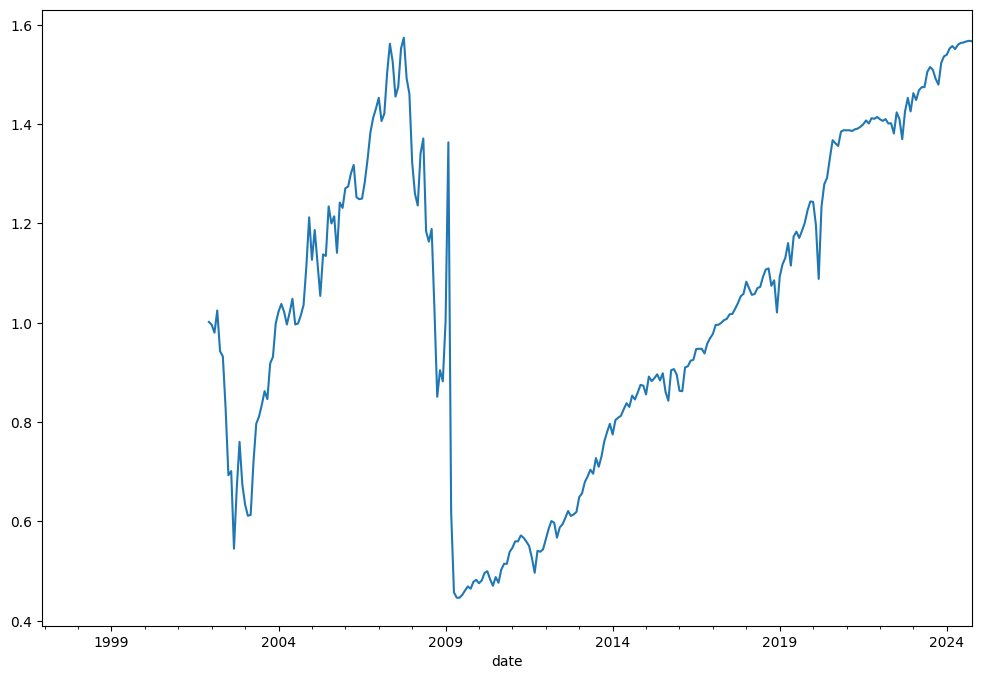

In [96]:
ep_dp_oos_weight = 100 * oos_ep_dp['Predicted']
ep_dp_oos_strat = (ep_dp_oos_weight * oos_ep_dp['Actual']).astype(float)
(1 + ep_dp_oos_strat).cumprod().plot(figsize=(12,8)) # to plot cumulative returns -> use 1 + .cumprod()


#### Multi Factor Models - More than 3 Factors 

In [97]:
def calc_pricing_regression(rets, factors, intercept=True, adj=12):
    if intercept:
        factors = sm.add_constant(factors)
    summary = {f'{k} Beta': [] for k in factors.columns[1:]}
    summary['Alpha']  = []
    summary['R^2']    = []
    for asset in rets.columns:
        model = sm.OLS(rets[asset], factors).fit()
        for k, _ in summary.items():
            try:
                summary[k].append(model.params[k[:-5]])
            except:
                pass
        summary['R^2'].append(model.rsquared)
        summary['Alpha'].append(model.params[0] * adj)
            
    return pd.DataFrame(summary, index=rets.columns)

def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params

In [98]:
factors = pd.read_excel('./../homework/data/factor_pricing_data.xlsx', sheet_name='factors (excess returns)').set_index('Date')
portfolios = pd.read_excel('./../homework/data/factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)').set_index('Date')

from collections import defaultdict
from itertools import product
import statsmodels.api as sm

summary = defaultdict(list)
capm = sm.add_constant(factors['MKT'])
aqr = sm.add_constant(factors[['MKT', 'HML', 'RMW', 'UMD']])
ff3 = sm.add_constant(factors[['MKT', 'SMB', 'HML']])
ff5 = sm.add_constant(factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']])

col_names = product(['CAPM', 'AQR', 'FF3', 'FF5'], ['Alpha', 'R^2'])
col_names = list(map(lambda x: ' '.join(x), col_names))

summary = pd.DataFrame(0, index=portfolios.columns, columns=col_names)

models = [*zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5])]

for asset in portfolios.columns:
    asset_ret = portfolios[asset]
    for name, X in models:
        model = sm.OLS(asset_ret, X).fit()
        summary.loc[asset, f'{name} Alpha'] = model.params[0]
        summary.loc[asset, f'{name} R^2'] = model.rsquared
        

summary.head()

,CAPM Alpha,CAPM R^2,AQR Alpha,AQR R^2,FF3 Alpha,FF3 R^2,FF5 Alpha,FF5 R^2
Agric,0.001695,0.330534,0.000643,0.339175,0.001344,0.357393,0.000028,0.363375
Food,0.003818,0.366464,0.000579,0.464221,0.002980,0.416709,-0.000220,0.490799
Soda,0.003923,0.253740,0.001436,0.308354,0.002899,0.280459,-0.000153,0.313214
Beer,0.004953,0.333662,0.001422,0.420762,0.004569,0.362360,0.000846,0.442389
Smoke,0.006770,0.189975,0.002942,0.273489,0.005512,0.236211,0.000916,0.305338


In [99]:
summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12
# This gets the MAE of the linear regressions of each factors. MAE is > 2% annualized -> therefoe not supportive of the pricing model 

,MAE
CAPM Alpha,0.020402
AQR Alpha,0.022993
FF3 Alpha,0.023984
FF5 Alpha,0.031367


Regress the portfolio against the factors -> Cross sectional on the average portfolio returns against the etas 

In [100]:
frames = []

ts_premia = portfolios.mean() * 12 # average returns for each porfolio

for name, X in zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5]):
    pricing_regr = calc_pricing_regression(portfolios, X, intercept=False)
    res = calc_cross_sectional_regression(ts_premia, pricing_regr.iloc[:, :-2], intercept=False)
    res = res.rename({'Cross Sectional Regression': f'{name} CS'}, axis=1)
    frames.append(res)

summary_cs = pd.concat(frames, axis=1).fillna('')

# Move R^2 and MAE to the top
summary_cs = pd.concat([summary_cs.loc[['R^2', 'MAE']], summary_cs.drop(['R^2', 'MAE'])])
summary_cs_betas = summary_cs[summary_cs.index.str.contains('Beta')].copy()
summary_cs_betas.loc[:, 'Time Series'] = factors.mean().values * 12 
summary_cs_betas

,CAPM CS,AQR CS,FF3 CS,FF5 CS,Time Series
MKT Beta,0.086096,0.089125,0.102214,0.096486,0.086277
HML Beta,,-0.038711,-0.015204,-0.030994,0.008319
RMW Beta,,0.043748,,0.033605,0.025809
UMD Beta,,0.060747,,,0.047096
SMB Beta,,,-0.064485,-0.056991,0.029537
CMA Beta,,,,-0.011559,0.062709




# Replication and OOS Testing 

In [101]:
def oos_forecast(signals, asset, t = 60, rolling = False, roll_exp = False, intercept = True):
    
    '''
    Computes an out-of-sample forecast based on expanding regression periods
    
    signals: DataFrame containing the signals (regressors) to be used in each regression
    asset: DataFrame containing the values (returns) of the asset being predicted
    t: The minimum number of periods
    rolling: False if expanding, else enter an integer window
    roll_exp: If using rolling, indicate whether to use expanding up to the minimum periods 
    intercept: Boolean indicating the inclusion of an intercept in the regressions
    '''
    n = len(signals)
    if intercept:
        signals = sm.add_constant(signals)
    if t > n:
        raise ValueError('Min. periods (t) greater than number of data points')
    output = pd.DataFrame(index = signals.index, columns = ['Actual','Predicted','Null'])
    if not rolling:
        for i in range(t,n):
            y = asset.iloc[:i]
            x = signals.iloc[:i].shift()
            if intercept:
                null_pred = y.mean()
            else:
                null_pred = 0
            model = sm.OLS(y,x,missing='drop').fit()
            pred_x = signals.iloc[[i - 1]]
            pred = model.predict(pred_x)[0]
            output.iloc[i]['Actual'] = asset.iloc[i]
            output.iloc[i]['Predicted'] = pred
            output.iloc[i]['Null'] = null_pred
    
    else:
        if rolling > n:
            raise ValueError('Rolling window greater than number of data points')
        y = asset
        x = signals.shift()
        if intercept:
            if roll_exp:
                null_pred = y.rolling(window = rolling, min_periods = 0).mean().shift()
            else:
                null_pred = y.rolling(window = rolling).mean().shift()
        else:
            null_pred = 0
        
        # When expanding == True, there is a minimum number of observations
        # Keep ^ in mind
        model = RollingOLS(y,x,window = rolling, expanding = roll_exp).fit()
        output['Actual'] = asset
        output['Predicted'] = (model.params * signals).dropna().sum(axis=1).shift()
        output['Null'] = null_pred
    return output


def oos_r_squared(data):
    
    '''
    Computes the out-of-sample r squared
    data: DataFrame containing actual, model-predicted, and null-predicted values
    '''
    model_error = data['Actual'] - data['Predicted']
    null_error = data['Actual'] - data['Null']
    
    r2_oos = 1 - (model_error ** 2).sum() / (null_error ** 2).sum()
    return r2_oos 

In [102]:
def OOS_r2(df, factors, start):
    y = df['SPY']
    X = sm.add_constant(factors)

    forecast_err, null_err = [], []

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            null_forecast = currY.mean()
            reg_predict = reg.predict(X.iloc[[i]])
            actual = y.iloc[[i]]
            forecast_err.append(reg_predict - actual)
            null_err.append(null_forecast - actual)
            
    RSS = (np.array(forecast_err)**2).sum()
    TSS = (np.array(null_err)**2).sum()
    
    return ((1 - RSS/TSS),reg)

In [103]:
def OOS_strat(df, factors, start):
    # start - start from the next index in the dataframe 
    y = df
    X = sm.add_constant(factors)

    forecast_err, null_err,oos_predictions,null_predictions = [], [],[],[]
    # null prediction: mean of all observed values up to tim ei 

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            null_forecast = currY.mean()
            reg_predict = reg.predict(X.iloc[[i]])
            actual = y.iloc[[i]]
            oos_predictions.append(reg_predict.T)
            null_predictions.append(pd.DataFrame([[reg_predict.index[0]]], columns = ['date'], index = [null_forecast]))
            forecast_err.append(reg_predict.values - actual)
            null_err.append(null_forecast.values - actual)
            
    RSS = (np.array(forecast_err)**2).sum()
    TSS = (np.array(null_err)**2).sum()
    # this is to compare the regression's model performance against the null model 
    
    predictions_df = pd.concat(oos_predictions).T.drop_duplicates()
    null_predictions_df = pd.concat(null_predictions).T
    
    return ((1 - RSS/TSS),reg,predictions_df,null_predictions_df)


In [104]:
forecasting = pd.read_excel('./Finals Sample/final_exam_data.xlsx',sheet_name='forecasting',index_col=0)
factor = forecasting.loc[:,['Tnote rate','Tnote rate change']].shift(1)
fund_ret = forecasting.loc[factor.index[0]:,['USO']]

# Qn: forecast values of USO for Jan 2018 through Dec 2023. Therefore, start from beginning of 2018. use .loc[:'2017'.shape[0] -> begins again) 
OOS_r2, OOS_reg_params, OOS_forecasts, null_predictions_df = OOS_strat(fund_ret,factor, forecasting.loc[:'2017'].shape[0])
# null predictions is just using the average
OOS_forecasts

date
2018-01-31   -0.007559
2018-02-28    0.002248
2018-03-31   -0.005113
2018-04-30   -0.011960
2018-05-31   -0.002330
                ...   
2023-07-31   -0.006231
2023-08-31   -0.006372
2023-09-30   -0.007037
2023-10-31    0.019210
2023-11-30   -0.002345
Length: 71, dtype: float64

In [ ]:
# (oos_ep_dp['Predicted'].dropna() < 0).sum() / len(oos_ep_dp['Predicted'].dropna())

#### Time Diversification


In [105]:
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [106]:
factors_log = np.log(factors + 1) 
factors_log.head()


,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.053636,0.018135,0.017349,-0.017146,0.016267,0.072786
1980-02-29,-0.012275,-0.015825,0.006081,0.000400,0.026447,0.075849
1980-03-31,-0.138113,-0.071818,-0.010151,0.014494,-0.011971,-0.100373
1980-04-30,0.038932,0.010445,0.010544,-0.021224,0.002896,-0.004309
1980-05-31,0.051263,0.020880,0.003793,0.003394,-0.003105,-0.011263


In [107]:
# to get the 15 year stats on the log returns for each factors
portfolio_metrics_basic(factors_log, 12*15) # annualization_factor = 12* 15 (for 15 year stats


,Annnualized Return,Annnualized Vol,Annnualized SR
MKT,1.103228,0.615188,1.793318
SMB,0.047477,0.393233,0.120735
HML,0.296544,0.425182,0.697452
RMW,0.653096,0.323676,2.017743
CMA,0.402854,0.281652,1.430324
UMD,0.751422,0.621353,1.209332


In [108]:
# to get the 1 year stats on the log returns for each factors
summary = portfolio_metrics_basic(factors_log, 12)
summary.head()

,Annnualized Return,Annnualized Vol,Annnualized SR
MKT,0.073549,0.158841,0.463033
SMB,0.003165,0.101532,0.031174
HML,0.019770,0.109782,0.180081
RMW,0.043540,0.083573,0.520979
CMA,0.026857,0.072722,0.369308


In [109]:
# Pr that the factor has a negative excess mean return -> use the summary results 

from scipy.stats import norm

def prob(mu, sigma, h):
    '''
    mu: expected returns, sigma: sd of returns, h: periods (annual)
    '''
    
    return norm.cdf(np.sqrt(h)*mu/sigma)

# Single period (1month) 
prob_1_month = 1 - prob(summary.loc['UMD', 'Annnualized Return'], summary.loc['UMD', 'Annnualized Vol'], 1 / 12)

# 15 year
prob_15_year = 1 - prob(summary.loc['UMD', 'Annnualized Return'], summary.loc['UMD', 'Annnualized Vol'], 15)

# Print
print(f"Probability of positive UMD in a single month: {prob_1_month:.2%}")
print(f"Probability of positive UMD in 15 years: {prob_15_year:.6%}")


Probability of positive UMD in a single month: 46.41%
Probability of positive UMD in 15 years: 11.326775%


In [110]:
# Pr that the Momentum outperforms the market factor
umd_mkt_spread = factors_log['UMD'] - factors_log['MKT']
umd_mkt_spread = umd_mkt_spread.loc['2009':]

umd_mkt_mean = umd_mkt_spread.mean() * 12
umd_mkt_std = umd_mkt_spread.std() * np.sqrt(12)

prob_outperf_1_month = prob(umd_mkt_mean, umd_mkt_std, 1 / 12)
prob_outperf_15_year = prob(umd_mkt_mean, umd_mkt_std, 15)

print(f"Probability of UMD outperforming the market in a single month: {prob_outperf_1_month:.2%}")
print(f"Probability of UMD outperforming the market in 15 years: {prob_outperf_15_year:.2%}")

Probability of UMD outperforming the market in a single month: 43.45%
Probability of UMD outperforming the market in 15 years: 1.35%


# FX

* has to be in log terms for the exchange rates, log(1+rf) for risk free rates

In [111]:
risk_free_rates = pd.read_excel(
    ".././data/fx_rf_data.xlsx",
    sheet_name="risk-free rates",
    index_col=0,
    parse_dates=[0],
)
exchange_rates = pd.read_excel(
    ".././data/fx_rf_data.xlsx", sheet_name="exchange rates", index_col=0, parse_dates=[0]
)

risk_free_rates = risk_free_rates / 252 
risk_free_rates = np.log(1 + risk_free_rates)
exchange_rates = np.log(exchange_rates)
exchange_rates.isna().sum(), risk_free_rates.isna().sum()

(JPY    0
 EUR    0
 GBP    0
 MXN    1
 CHF    0
 dtype: int64,
 USD    0
 JPY    0
 EUR    0
 GBP    0
 MXN    0
 CHF    0
 dtype: int64)

## Performance of the currencies -> is there a premium 
- UIP: mean return of the currencies = 0 as change in spot fx rate is explained by changes in risk free rates

* Note: the fx data may not be entirely filled -> check for null values
* ##### .fillna(method = 'ffill')

In [112]:
rets = pd.DataFrame(data=0, index=exchange_rates.index, columns=exchange_rates.columns)
for col in exchange_rates.columns:
    rets[col] = (
        exchange_rates[col].shift(-1) # Gets spot_{t+1}
        - exchange_rates[col]         # Gets spot_{t}
        + risk_free_rates[col]        # Risk free rate at time t -> t+1
        - risk_free_rates["USD"]      # Local risk free rate at time t -> t+1
    )

# rets = rets.dropna()
rets = rets.dropna()
performance_summary(rets, 0.05, 
                                          252) #the performance metrics 

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
JPY,-0.029160,0.099118,-0.294196,0.115487,5.357110,-0.009565,-0.014238,-0.054782,0.038367,-0.621615,2011-10-27,2024-07-09,NaT
EUR,-0.023121,0.090045,-0.256769,0.108786,2.363928,-0.008946,-0.012915,-0.024265,0.034517,-0.481967,2008-07-10,2022-09-26,NaT
GBP,-0.024334,0.095666,-0.254368,-0.831300,11.320368,-0.009312,-0.014025,-0.083953,0.030997,-0.509471,2008-03-12,2022-09-23,NaT
MXN,0.013094,0.129978,0.100743,-0.703716,7.800414,-0.012706,-0.019635,-0.079343,0.066764,-0.409320,2008-08-01,2017-01-18,2023-05-09
CHF,0.003116,0.106857,0.029159,5.139145,169.679610,-0.009184,-0.013342,-0.090926,0.194949,-0.418429,2011-08-08,2022-11-02,NaT
